In [1]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses



### 먼저 포켓못 색칠로 연습을 해보겠습니다.

In [2]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


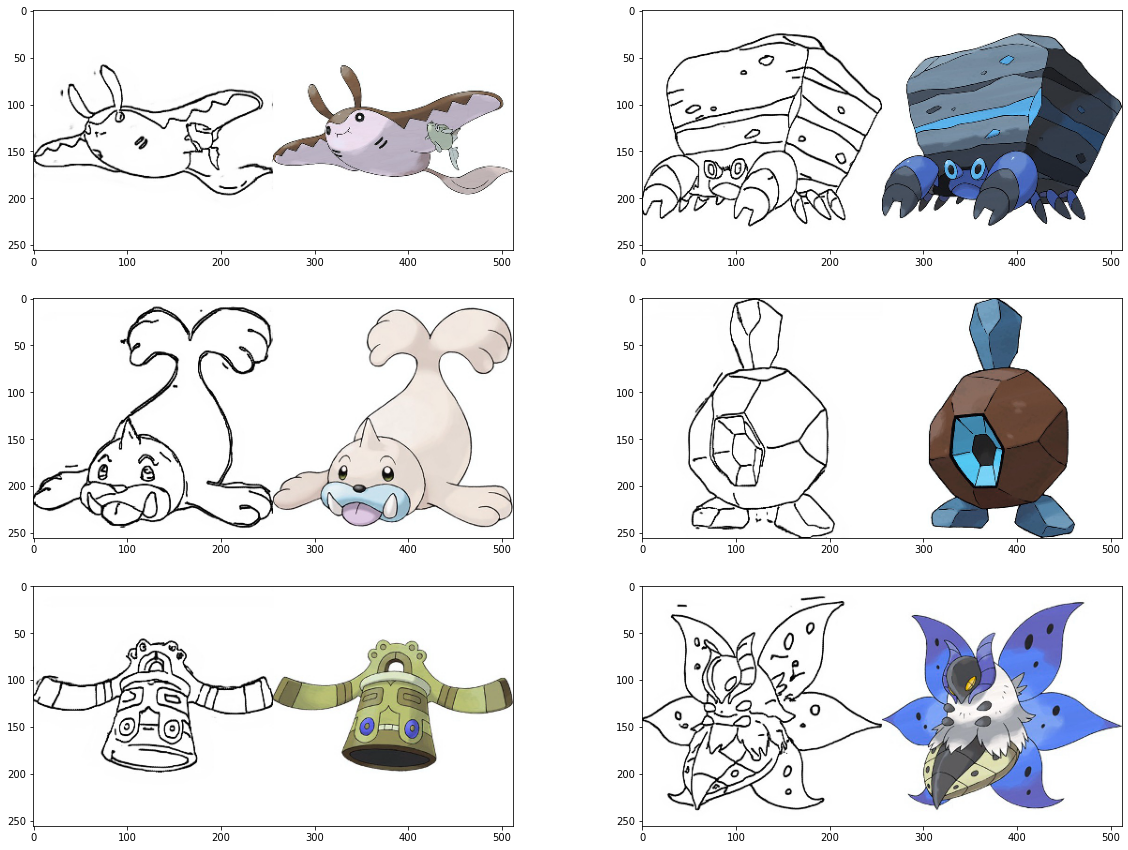

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


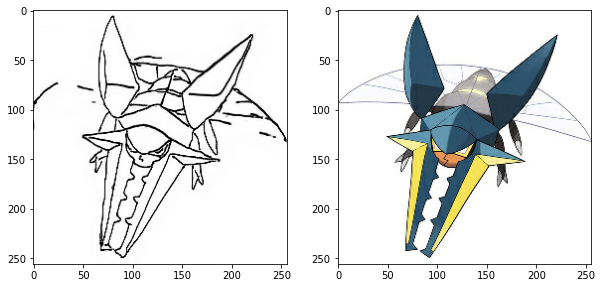

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## $\bullet$ 이미지 Augmentation

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


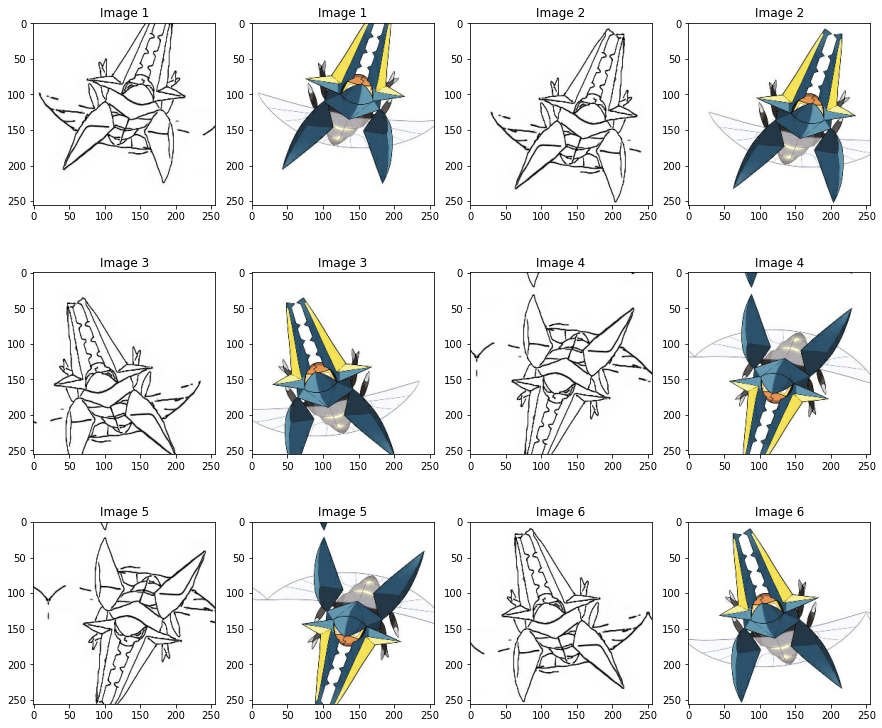

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

### 위에서 봤듯이 스케치와 완성 사진이 같이 붙어있으므로, 그 결과를 얻는 함수를 만들어줍니다.

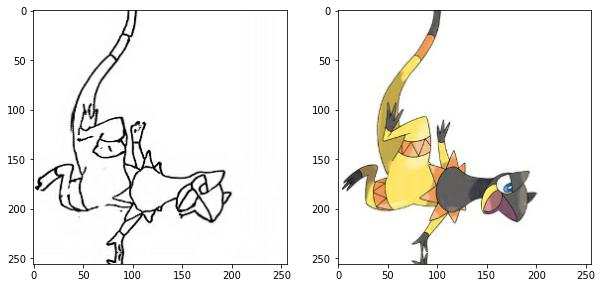

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### 이제 Unet의 구조로 Generator를 만들것입니다!!

In [11]:
from tensorflow.keras import layers, Input, Model

In [12]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [13]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### 안그래도 Unet 보고싶었는데ㅜㅜ 구현까지 해주시다니 너무 감동입니다ㅜㅜ
### 안쪽을 보시면 Encoder_block과 Decoder_block을 만들어서 인풋을 차례로 거치면서, skipconnection까지 완벽하게 하는 것을 볼 수 있습니다!!
### 안그래도 skipconnection어떻게 하라는 건지 궁금했는데, keras의 layers.Concatenate()함수를 이용하여, 자연스럽게 Residual을 만들어주는 걸 볼수 있습니다. 그마저도... 마법처럼 짧고 직관적인 코드로 완성되어 있습니다. 감동ㅜㅜ

In [15]:
UNetGenerator().get_summary()

ResourceExhaustedError: in user code:

    <ipython-input-12-8140ecf0b7b4>:10 call  *
        x = self.conv(x)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1008 __call__  **
        self._maybe_build(inputs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py:205 build
        dtype=self.dtype)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:639 add_weight
        caching_device=caching_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py:810 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:221 _variable_v1_call
        shape=shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:199 <lambda>
        previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py:2618 default_variable_creator
        shape=shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1585 __init__
        distribute_strategy=distribute_strategy)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1712 _init_from_args
        initial_value = initial_value()
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:410 __call__
        shape, dtype=_get_dtype(dtype), **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/init_ops_v2.py:600 __call__
        return self._random_generator.random_uniform(shape, -limit, limit, dtype)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/init_ops_v2.py:1082 random_uniform
        shape=shape, minval=minval, maxval=maxval, dtype=dtype, seed=self.seed)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/random_ops.py:308 random_uniform
        result = math_ops.add(result * (maxval - minval), minval, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1496 _mul_dispatch
        return multiply(x, y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:518 multiply
        return gen_math_ops.mul(x, y, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6068 mul
        _ops.raise_from_not_ok_status(e, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[4,4,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]
